# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa import arima_process
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

from statsmodels.datasets import nile
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

from pmdarima import auto_arima

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data into 'vehicles' dataframe
vehicles = pd.read_csv('data/vehicles.csv')
vehicles

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy


In [3]:
# Let's explore the details about the vehicles dataframe
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# Looks like there are a few null values. Let's look at the count of null values by each column
check_veh = pd.DataFrame(vehicles.isna().sum(axis = 0),columns=['Nulls'])
check_veh['Percentage'] = round(check_veh/426880,2)
check_veh

,Nulls,Percentage
id,0,0.00
region,0,0.00
price,0,0.00
year,1205,0.00
manufacturer,17646,0.04
model,5277,0.01
condition,174104,0.41
cylinders,177678,0.42
fuel,3013,0.01
odometer,4400,0.01


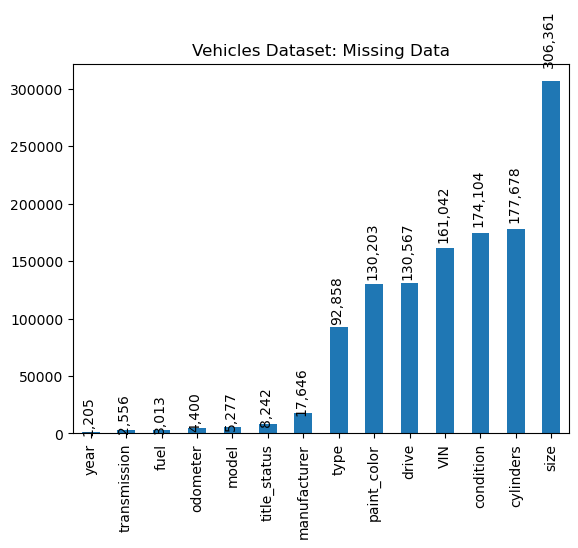

In [5]:
# Let's plot the missing data

missing = vehicles.isna().sum(axis = 0)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
ax = missing.plot.bar(title='Vehicles Dataset: Missing Data')
for p in ax.patches:
    ax.annotate("{:,}".format(int(p.get_height())), (p.get_x() * 1, p.get_height() * 1.05),rotation=90)
plt.show()

In [6]:
# Looks like we have all rows with some price value for the car. Let's see if there are any abnormality in the price values

print(f'price - min: {vehicles.price.min()}, price - max : {vehicles.price.max():,}')

price - min: 0, price - max : 3,736,928,711


<Axes: xlabel='year', ylabel='price'>

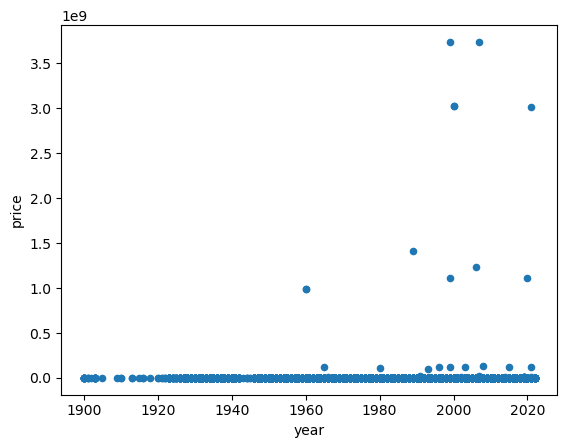

In [7]:
# Looks like there are outliers in the price data. Let's plot price data on the chart

vehicles.plot(kind='scatter',x='year', y='price', style='o')

In [8]:
# Due to the anomoly in the data, we are unable to see the plot correctly. Let's find out how many records have 
# price = 0
# price > 2 Million 

print (f'Total number of vehicles with price = 0         are : {vehicles.price.eq(0).sum(axis=0):,}')
print (f'Total number of vehicles with price < 100       are : {vehicles.price.lt(100).sum(axis=0):,}')
print (f'Total number of vehicles with price > 2 million are : {vehicles.price.gt(2000000).sum(axis=0):,}')
print (f'Total number of vehicles with price > 500,000   are : {vehicles.price.gt(500000).sum(axis=0):,}')

Total number of vehicles with price = 0         are : 32,895
Total number of vehicles with price < 100       are : 36,222
Total number of vehicles with price > 2 million are : 33
Total number of vehicles with price > 500,000   are : 68


In [9]:
# Based on above data, it looks like we should remove price = 0 as we cannot predict the value of the used car (cannot be zero) 
# and we want to eliminate any used car above 500,000 to help us have better test and validation dataset
# Although the data looks incorrect with price of car with 1, 2, 3... 100, ... 1000, we want to keep it. 
# We don't know if the value is accurate or input

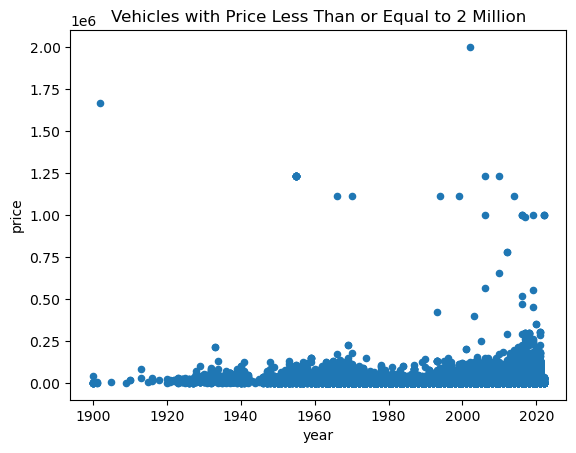

In [10]:
# Let's plot the data excluding the outliers where price > 2M and price not equal to zero

vehicles[vehicles.price.ne(0) & vehicles.price.le(2000000)].plot(kind='scatter',x='year', y='price', style='o')
plt.title('Vehicles with Price Less Than or Equal to 2 Million')
plt.show()

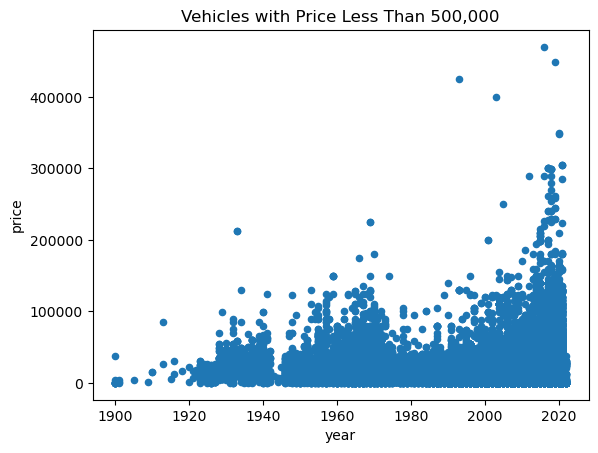

In [11]:
# We still see lots of anomolies with price greater than 500,000 and price = 0. 
# So let's exclude them as well and see how the data shows for price

vehicles[vehicles.price.ne(0) & vehicles.price.lt(500000)].plot(kind='scatter',x='year', y='price', style='o')
plt.title('Vehicles with Price Less Than 500,000')
plt.show()

In [12]:
# Let's look at the values in the title_status column

vehicles.title_status.unique()

array([nan, 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

In [13]:
# The title has Nulls, Clean, Rebuilt, Lien, Salvage, Missing, Parts Only

In [14]:
# Let's find out how many rows have Clean title but the price is zero
# This shows that the data is incorrect. Let's remove these records as well
vehicles[(vehicles.price == 0) & (vehicles.title_status == 'clean')].shape

(32250, 18)

In [15]:
# Let's look at the title status for all records with price = 0
vehicles[(vehicles.price == 0)].groupby('title_status')['title_status'].count()

title_status
clean         32250
lien              1
missing          17
parts only        9
rebuilt          79
salvage          31
Name: title_status, dtype: int64

In [16]:
# Let's find out how many records will get excluded if we remove the following:
# Records with year as null
# Records with price Less Than or Equal to Zero
# Records with price Greater Than or Equal to 500,000
# Original record count was 426,880
vehicles[vehicles['year'].notna() & vehicles['price'].gt(0) & vehicles['price'].lt(500000)].shape

(392744, 18)

In [17]:
# Based on the results, it looks like we will remove 426,880 - 392,744 = 34,136 records

In [18]:
# Without an accurate price (32,895 records with price = 0) and 
# with anomolies in the price values (68 records with > 500,000),
# it would be difficult to consider the mean price for all the vehicles
# So we will exclude these rows
# Also, we need a value in column year. so we will remove any null values for year
# This should result in 392,744 records

clean_vehicles = vehicles[vehicles['year'].notna() & vehicles['price'].gt(0) & vehicles['price'].lt(500000)]
clean_vehicles.shape

(392744, 18)

In [19]:
# Let's look at the first 10 rows of the clean dataset
clean_vehicles.head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white,al
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue,al
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,NaN,NaN,pickup,red,al
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,al
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,al
32,7316343444,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,1GT220CG8CZ231238,4wd,NaN,pickup,black,al
33,7316304717,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,1GCVKREH6GZ228691,4wd,NaN,pickup,silver,al
34,7316285779,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,NaN,4wd,NaN,truck,grey,al
35,7316257769,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,1GCHTCE37G1186784,4wd,NaN,pickup,red,al
36,7316133914,auburn,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,gas,30237.0,clean,other,1G1YR3DW3B5102190,rwd,NaN,other,red,al


In [20]:
# Since we have to determine what drives the price of a car, let's find out the minimum and maximum value of the car price
clean_vehicles.price.min(), clean_vehicles.price.max() 

(1, 470000)

In [21]:
# We still see fake data in the price value. However, to ensure we keep original data, I am not going to distrub these records
# Let's look at the price of used cars where price is between 1 and 10
for i in range(1,11):
    print(i, clean_vehicles[clean_vehicles['price'].eq(i)].price.count())

1 1951
2 13
3 9
4 4
5 16
6 12
7 8
8 7
9 14
10 26


In [22]:
# Now that we have clean vehicle data that we are comfortable to use, let's find out how of the other columns have missing data
clean_vehicles.isna().sum(axis=0)

id                   0
region               0
price                0
year                 0
manufacturer     15005
model             4616
condition       150176
cylinders       160301
fuel              2335
odometer          2227
title_status      7430
transmission      1761
VIN             152039
drive           119930
size            281712
type             85714
paint_color     116966
state                0
dtype: int64

In [23]:
# Let's also find out the data types of each of the columns to see if we can apply mean value on numeric data
clean_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392744 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            392744 non-null  int64  
 1   region        392744 non-null  object 
 2   price         392744 non-null  int64  
 3   year          392744 non-null  float64
 4   manufacturer  377739 non-null  object 
 5   model         388128 non-null  object 
 6   condition     242568 non-null  object 
 7   cylinders     232443 non-null  object 
 8   fuel          390409 non-null  object 
 9   odometer      390517 non-null  float64
 10  title_status  385314 non-null  object 
 11  transmission  390983 non-null  object 
 12  VIN           240705 non-null  object 
 13  drive         272814 non-null  object 
 14  size          111032 non-null  object 
 15  type          307030 non-null  object 
 16  paint_color   275778 non-null  object 
 17  state         392744 non-null  object 
dtypes: float

In [24]:
# Since there are no missing values for id, region, price, and year, we can use the data as is. 
# The only other numeric data is odometer. We find that there are some missing records
# Let's populate the missing data with mean value
# Before we do that, let's see if there are any rows in odometer with value = zero

clean_vehicles.odometer.min(), clean_vehicles.odometer.max()

(0.0, 10000000.0)

In [25]:
# We see some more anomolies. We see used cars with odometer = 0. This is incorrect. We also see odometer = 10 million. 
# Most cars have a maximum odometer around 200,000. 
# However, to ensure we keep the data intact, we will remove any odometer that is more than 1 million

clean_vehicles[clean_vehicles.odometer.eq(0)].odometer.count(), clean_vehicles[clean_vehicles.odometer.gt(1000000)].odometer.count()

(1102, 462)

In [26]:
clean_vehicles[clean_vehicles.VIN=='JTJYARBZ5G2041512']

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
116,7306676175,auburn,26990,2016.0,lexus,nx 200t sport utility 4d,good,NaN,gas,31363.0,clean,other,JTJYARBZ5G2041512,fwd,NaN,hatchback,white,al


In [27]:
# Let's remove the records with odometer equal to 0 and odometer greater than 1,000,000 (1 million)

clean_vehicles.drop(clean_vehicles[clean_vehicles.odometer.eq(0)].index, inplace=True)
clean_vehicles.drop(clean_vehicles[clean_vehicles.odometer.gt(1000000)].index, inplace=True)

#clean_vehicles = clean_vehicles[clean_vehicles.odometer.ne(0) & clean_vehicles.odometer.lt(1000000)]

# Let's now look at the clean_vehicles dataset information
clean_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391180 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            391180 non-null  int64  
 1   region        391180 non-null  object 
 2   price         391180 non-null  int64  
 3   year          391180 non-null  float64
 4   manufacturer  376480 non-null  object 
 5   model         386619 non-null  object 
 6   condition     241575 non-null  object 
 7   cylinders     231492 non-null  object 
 8   fuel          388880 non-null  object 
 9   odometer      388953 non-null  float64
 10  title_status  384001 non-null  object 
 11  transmission  389419 non-null  object 
 12  VIN           239758 non-null  object 
 13  drive         271922 non-null  object 
 14  size          110680 non-null  object 
 15  type          305982 non-null  object 
 16  paint_color   274894 non-null  object 
 17  state         391180 non-null  object 
dtypes: float

In [28]:
# There are still some missing values. Let's explore odometer and see how many of them are missing values

clean_vehicles.odometer.isna().sum(axis=0)

2227

In [29]:
# Similar to price, let's find out if odometer is also overwritten with low values. 
# If so, then we have fake data in the odometer column as well. 
# To ensure we keep original data, I am not going to distrub these records
# Let's look at the odometer of used cars where odometer is between 1 and 10
for i in range(1,11):
    print(i, clean_vehicles[clean_vehicles['odometer'].eq(i)].odometer.count())

1 1890
2 119
3 49
4 135
5 165
6 31
7 56
8 35
9 25
10 331


In [30]:
# Let's find out the total number of records with odometer less than 100
x = clean_vehicles[clean_vehicles['odometer'].le(100)].odometer.count()
print ('Total number of records with odometer less than or equal to 100 :', x)

Total number of records with odometer less than or equal to 100 : 4083


In [31]:
# This tells us that the data is not accurate. However, we will go ahead and use the mean value to populate missing odometer values

In [32]:
# Let's look at the first 10 rows of the clean dataset that has missing odometer values

clean_vehicles[clean_vehicles.odometer.isna()].head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
541,7313589313,birmingham,18950,2009.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
772,7311452208,birmingham,14950,2007.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,silver,al
1030,7309386327,birmingham,19950,2008.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,black,al
1244,7306994204,birmingham,17950,2009.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,black,al
1245,7306994088,birmingham,15950,2008.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
1246,7306993994,birmingham,16950,2007.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,red,al
1247,7306993889,birmingham,22950,2013.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
1248,7306993794,birmingham,32950,2016.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,red,al
1249,7306993678,birmingham,28950,2017.0,jeep,wrangler unlimited,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,silver,al
5455,7314992435,anchorage / mat-su,66840,2019.0,ram,1500,NaN,NaN,gas,NaN,clean,automatic,1C6SRFPT7KN512563,4wd,NaN,pickup,NaN,ak


In [33]:
# Let's keep track of the index numbers for the missing odometer values
odo_first_10 = clean_vehicles[clean_vehicles.odometer.isna()].index[:10].tolist()

In [34]:
# Let's look at the data for the first 10 rows that have missing odometer
clean_vehicles.loc[odo_first_10]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
541,7313589313,birmingham,18950,2009.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
772,7311452208,birmingham,14950,2007.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,silver,al
1030,7309386327,birmingham,19950,2008.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,black,al
1244,7306994204,birmingham,17950,2009.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,black,al
1245,7306994088,birmingham,15950,2008.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
1246,7306993994,birmingham,16950,2007.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,red,al
1247,7306993889,birmingham,22950,2013.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
1248,7306993794,birmingham,32950,2016.0,jeep,wrangler,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,red,al
1249,7306993678,birmingham,28950,2017.0,jeep,wrangler unlimited,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,silver,al
5455,7314992435,anchorage / mat-su,66840,2019.0,ram,1500,NaN,NaN,gas,NaN,clean,automatic,1C6SRFPT7KN512563,4wd,NaN,pickup,NaN,ak


In [35]:
# Quick check. Let's find out how many missing odometer values we still have in our clean_vehicles dataset
clean_vehicles.odometer.isna().sum(axis=0)

2227

In [36]:
# There are 2227 rows with missing values. Let's replace the missing values with mean of the odometer values
clean_vehicles.odometer.fillna(round(clean_vehicles.odometer.mean()), inplace=True)
# Let's find out if there are any more missing values for odometer after we updated them with mean values. We should get a result of 0
clean_vehicles.odometer.isna().sum(axis=0)

0

In [37]:
# Let's use the same index numbers and find out what values were changed for odometer
clean_vehicles.loc[odo_first_10]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
541,7313589313,birmingham,18950,2009.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
772,7311452208,birmingham,14950,2007.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,NaN,NaN,NaN,silver,al
1030,7309386327,birmingham,19950,2008.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,4wd,NaN,NaN,black,al
1244,7306994204,birmingham,17950,2009.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,NaN,NaN,NaN,black,al
1245,7306994088,birmingham,15950,2008.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
1246,7306993994,birmingham,16950,2007.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,NaN,NaN,NaN,red,al
1247,7306993889,birmingham,22950,2013.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,al
1248,7306993794,birmingham,32950,2016.0,jeep,wrangler,excellent,NaN,gas,94239.0,clean,automatic,NaN,4wd,NaN,NaN,red,al
1249,7306993678,birmingham,28950,2017.0,jeep,wrangler unlimited,excellent,NaN,gas,94239.0,clean,automatic,NaN,4wd,NaN,NaN,silver,al
5455,7314992435,anchorage / mat-su,66840,2019.0,ram,1500,NaN,NaN,gas,94239.0,clean,automatic,1C6SRFPT7KN512563,4wd,NaN,pickup,NaN,ak


In [38]:
# Now let's find out the unique values in each of the columns. If there are less than 10 values, let's identify them
cols = []
for col in clean_vehicles.columns:
    if clean_vehicles[col].nunique() < 10: 
        cols.append(col)
        print (col, clean_vehicles[col].nunique(), clean_vehicles[col].unique(), '\n')

condition 6 ['good' 'excellent' 'fair' nan 'like new' 'new' 'salvage'] 

cylinders 8 ['8 cylinders' '6 cylinders' nan '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders'] 

fuel 5 ['gas' 'other' 'diesel' 'hybrid' nan 'electric'] 

title_status 6 ['clean' 'rebuilt' 'lien' nan 'salvage' 'missing' 'parts only'] 

transmission 3 ['other' 'automatic' 'manual' nan] 

drive 3 [nan 'rwd' '4wd' 'fwd'] 

size 4 [nan 'full-size' 'mid-size' 'compact' 'sub-compact'] 



In [39]:
# Let's find out how many unique values we have for VIN number
clean_vehicles.VIN.nunique(), clean_vehicles.shape[0]

(104712, 391180)

In [40]:
# Let's find out how many duplicate VINs we have in the dataset
x = clean_vehicles.groupby('VIN')['VIN'].count() > 1
x[x == True].count()

35555

In [41]:
# Let's list the first 10 duplicate VINs
x[x == True].head(10)

VIN
0                    True
0000000RN47028886    True
0000000T05H107426    True
0000000V264204442    True
0000004Y83Z146570    True
000000ECR33107314    True
000000F1BH525035     True
000000VC55J202641    True
00000HDJ810018347    True
00000ST2050009277    True
Name: VIN, dtype: bool

In [42]:
# Let's find the rows for one of the VINs
clean_vehicles[clean_vehicles.VIN=='0000000RN47028886']

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
10177,7316776056,phoenix,29995,1980.0,toyota,pickup,NaN,NaN,other,1.0,clean,other,0000000RN47028886,NaN,NaN,truck,NaN,az
52708,7316257561,sacramento,29995,1980.0,toyota,pickup,NaN,NaN,other,1.0,clean,other,0000000RN47028886,NaN,NaN,truck,NaN,ca
248067,7314366584,las vegas,29995,1980.0,toyota,pickup,NaN,NaN,other,1.0,clean,other,0000000RN47028886,NaN,NaN,truck,NaN,nv


In [43]:
# Now let's remove all duplicates VINs and keep only the last one
clean_vehicles.drop_duplicates(subset='VIN', keep="last", inplace=True)

In [44]:
# Let's check if the last id was kept while all others were removed
clean_vehicles[clean_vehicles.VIN=='0000000RN47028886']

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
248067,7314366584,las vegas,29995,1980.0,toyota,pickup,NaN,NaN,other,1.0,clean,other,0000000RN47028886,NaN,NaN,truck,NaN,nv


#### VIN Number
we know that VIN number does not provide any value in determining the car price. So we can easily drop that column

In [45]:
clean_vehicles.drop(columns=['VIN'], inplace=True)

#### id

We know that id does not provide any value in determining the car price. So we can easily drop this column too

In [46]:
clean_vehicles.drop(columns=['id'], inplace=True)

In [47]:
clean_vehicles.state.unique()

array(['al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
       'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
       'mi', 'mn', 'ms', 'mo', 'mt', 'nc', 'ne', 'nv', 'nj', 'nm', 'ny',
       'nh', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
       'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy'], dtype=object)

In [48]:
clean_vehicles[clean_vehicles.state == 'fl'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6420 entries, 91983 to 120469
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        6420 non-null   object 
 1   price         6420 non-null   int64  
 2   year          6420 non-null   float64
 3   manufacturer  6240 non-null   object 
 4   model         6367 non-null   object 
 5   condition     3741 non-null   object 
 6   cylinders     3911 non-null   object 
 7   fuel          6383 non-null   object 
 8   odometer      6420 non-null   float64
 9   title_status  6255 non-null   object 
 10  transmission  6321 non-null   object 
 11  drive         5106 non-null   object 
 12  size          2305 non-null   object 
 13  type          5727 non-null   object 
 14  paint_color   5181 non-null   object 
 15  state         6420 non-null   object 
dtypes: float64(2), int64(1), object(13)
memory usage: 852.7+ KB


In [49]:
clean_vehicles.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
116,auburn,26990,2016.0,lexus,nx 200t sport utility 4d,good,NaN,gas,31363.0,clean,other,fwd,NaN,hatchback,white,al
187,birmingham,4500,2008.0,ford,mustang,NaN,6 cylinders,gas,187016.0,clean,automatic,rwd,NaN,coupe,red,al
190,birmingham,4299,2007.0,nissan,sentra,NaN,4 cylinders,gas,189321.0,clean,automatic,fwd,NaN,sedan,silver,al
199,birmingham,16988,2008.0,toyota,fj cruiser,NaN,NaN,gas,188099.0,clean,automatic,4wd,NaN,NaN,NaN,al
200,birmingham,16988,2018.0,nissan,altima,NaN,NaN,gas,57517.0,clean,automatic,fwd,NaN,NaN,silver,al
201,birmingham,26990,2018.0,nissan,frontier,NaN,NaN,gas,31814.0,clean,automatic,rwd,NaN,NaN,black,al
202,birmingham,32186,2021.0,toyota,tacoma,NaN,NaN,gas,1443.0,clean,automatic,rwd,NaN,NaN,NaN,al
203,birmingham,16477,2015.0,buick,enclave,NaN,NaN,gas,103969.0,clean,automatic,fwd,NaN,NaN,black,al
204,birmingham,58977,2019.0,gmc,sierra 3500,NaN,NaN,gas,66368.0,clean,automatic,4wd,NaN,NaN,white,al
219,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al


In [50]:
# Let's look at the count of null values by each column
x_tot = clean_vehicles.shape[0]
print ('Total number of records in clean_vehicles dataset is :',x_tot)
check_veh = pd.DataFrame(clean_vehicles.isna().sum(axis = 0),columns=['Nulls'])
check_veh['Percentage'] = round(check_veh/x_tot,2)
check_veh['good_data'] = x_tot - check_veh.Nulls
check_veh

Total number of records in clean_vehicles dataset is : 104713


,Nulls,Percentage,good_data
region,0,0.00,104713
price,0,0.00,104713
year,0,0.00,104713
manufacturer,2228,0.02,102485
model,509,0.00,104204
condition,48176,0.46,56537
cylinders,40714,0.39,63999
fuel,1270,0.01,103443
odometer,0,0.00,104713
title_status,3068,0.03,101645


In [51]:
clean_vehicles.year = clean_vehicles.year.astype('Int64')
clean_vehicles.odometer = clean_vehicles.odometer.astype('Int64')
clean_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104713 entries, 116 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        104713 non-null  object
 1   price         104713 non-null  int64 
 2   year          104713 non-null  Int64 
 3   manufacturer  102485 non-null  object
 4   model         104204 non-null  object
 5   condition     56537 non-null   object
 6   cylinders     63999 non-null   object
 7   fuel          103443 non-null  object
 8   odometer      104713 non-null  Int64 
 9   title_status  101645 non-null  object
 10  transmission  103814 non-null  object
 11  drive         81419 non-null   object
 12  size          27314 non-null   object
 13  type          90775 non-null   object
 14  paint_color   79025 non-null   object
 15  state         104713 non-null  object
dtypes: Int64(2), int64(1), object(13)
memory usage: 13.8+ MB


In [52]:
clean_vehicles.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
116,auburn,26990,2016,lexus,nx 200t sport utility 4d,good,NaN,gas,31363,clean,other,fwd,NaN,hatchback,white,al
187,birmingham,4500,2008,ford,mustang,NaN,6 cylinders,gas,187016,clean,automatic,rwd,NaN,coupe,red,al
190,birmingham,4299,2007,nissan,sentra,NaN,4 cylinders,gas,189321,clean,automatic,fwd,NaN,sedan,silver,al
199,birmingham,16988,2008,toyota,fj cruiser,NaN,NaN,gas,188099,clean,automatic,4wd,NaN,NaN,NaN,al
200,birmingham,16988,2018,nissan,altima,NaN,NaN,gas,57517,clean,automatic,fwd,NaN,NaN,silver,al
201,birmingham,26990,2018,nissan,frontier,NaN,NaN,gas,31814,clean,automatic,rwd,NaN,NaN,black,al
202,birmingham,32186,2021,toyota,tacoma,NaN,NaN,gas,1443,clean,automatic,rwd,NaN,NaN,NaN,al
203,birmingham,16477,2015,buick,enclave,NaN,NaN,gas,103969,clean,automatic,fwd,NaN,NaN,black,al
204,birmingham,58977,2019,gmc,sierra 3500,NaN,NaN,gas,66368,clean,automatic,4wd,NaN,NaN,white,al
219,birmingham,2500,1995,bmw,525i,fair,6 cylinders,gas,110661,clean,automatic,rwd,mid-size,sedan,white,al


In [53]:
# Now let's find out the unique values in each of the columns. If there are less than 10 values, let's identify them
cols = []
for col in clean_vehicles.columns:
    if clean_vehicles[col].nunique() < 10: 
        cols.append(col)
        print (col, clean_vehicles[col].nunique(), clean_vehicles[col].unique(), '\n')

condition 6 ['good' nan 'fair' 'excellent' 'like new' 'new' 'salvage'] 

cylinders 8 [nan '6 cylinders' '4 cylinders' '8 cylinders' '5 cylinders'
 '10 cylinders' '12 cylinders' '3 cylinders' 'other'] 

fuel 5 ['gas' 'diesel' nan 'hybrid' 'other' 'electric'] 

title_status 6 ['clean' nan 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] 

transmission 3 ['other' 'automatic' 'manual' nan] 

drive 3 ['fwd' 'rwd' '4wd' nan] 

size 4 [nan 'mid-size' 'compact' 'full-size' 'sub-compact'] 



In [55]:
# Let's save this dataset as clean_vehicles_base. We can reuse this in the future for other evaluations.
clean_vehicles_base = clean_vehicles.copy(deep=True)

In [57]:
clean_vehicles_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104713 entries, 116 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        104713 non-null  object
 1   price         104713 non-null  int64 
 2   year          104713 non-null  Int64 
 3   manufacturer  102485 non-null  object
 4   model         104204 non-null  object
 5   condition     56537 non-null   object
 6   cylinders     63999 non-null   object
 7   fuel          103443 non-null  object
 8   odometer      104713 non-null  Int64 
 9   title_status  101645 non-null  object
 10  transmission  103814 non-null  object
 11  drive         81419 non-null   object
 12  size          27314 non-null   object
 13  type          90775 non-null   object
 14  paint_color   79025 non-null   object
 15  state         104713 non-null  object
dtypes: Int64(2), int64(1), object(13)
memory usage: 13.8+ MB


In [56]:
for col in clean_vehicles.columns:
    if clean_vehicles[col].isna().sum(axis = 0) > 0:
        clean_vehicles[col].fillna(clean_vehicles[col].mode()[0], inplace=True)

clean_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104713 entries, 116 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        104713 non-null  object
 1   price         104713 non-null  int64 
 2   year          104713 non-null  Int64 
 3   manufacturer  104713 non-null  object
 4   model         104713 non-null  object
 5   condition     104713 non-null  object
 6   cylinders     104713 non-null  object
 7   fuel          104713 non-null  object
 8   odometer      104713 non-null  Int64 
 9   title_status  104713 non-null  object
 10  transmission  104713 non-null  object
 11  drive         104713 non-null  object
 12  size          104713 non-null  object
 13  type          104713 non-null  object
 14  paint_color   104713 non-null  object
 15  state         104713 non-null  object
dtypes: Int64(2), int64(1), object(13)
memory usage: 13.8+ MB


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [60]:
# Now let's find out the unique values in each of the columns. If there are less than 10 values, let's identify them
cols = []
for col in clean_vehicles.columns:
    if clean_vehicles[col].nunique() < 10: 
        cols.append(col)
        print (col, clean_vehicles[col].nunique(), clean_vehicles[col].unique(), '\n')

condition 6 ['good' 'excellent' 'fair' 'like new' 'new' 'salvage'] 

cylinders 8 ['4 cylinders' '6 cylinders' '8 cylinders' '5 cylinders' '10 cylinders'
 '12 cylinders' '3 cylinders' 'other'] 

fuel 5 ['gas' 'diesel' 'hybrid' 'other' 'electric'] 

title_status 6 ['clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] 

transmission 3 ['other' 'automatic' 'manual'] 

drive 3 ['fwd' 'rwd' '4wd'] 

size 4 ['full-size' 'mid-size' 'compact' 'sub-compact'] 



In [61]:
# Let's look at the columns to encode
print (cols)

['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size']


In [59]:
# Let's use One Hot Encoding and other Encoding methods to convert these few columns into numeric data

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

    

['condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size']

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.